## Figure 1

Within-assay perturbation reproducibility and mechanism matching

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure1")
extensions <- c(".png", ".pdf")

### Panel A

In [3]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

cell_painting_pr_file <- file.path(results_dir, "cell_painting_percent_replicating_data.tsv.gz")
l1000_pr_file <- file.path(results_dir, "l1000_percent_replicating_data.tsv.gz")

In [4]:
pr_col_types <- readr::cols(
    dose = readr::col_character(),
    correlation_values = readr::col_double(),
    type = readr::col_character()
)

cell_painting_pr_df <- readr::read_tsv(cell_painting_pr_file, col_types = pr_col_types) %>% dplyr::mutate(assay = "Cell Painting")
l1000_pr_df <- readr::read_tsv(l1000_pr_file, col_types = pr_col_types) %>% dplyr::mutate(assay = "L1000")

pr_df <- dplyr::bind_rows(cell_painting_pr_df, l1000_pr_df)
pr_df$dose <- factor(pr_df$dose, levels = dose_order)

print(dim(pr_df))
head(pr_df)

[1] 634867      4


dose,correlation_values,type,assay
<fct>,<dbl>,<chr>,<chr>
0.04 uM,-0.04477752,true replicate,Cell Painting
0.04 uM,0.05604972,true replicate,Cell Painting
0.04 uM,0.03334181,true replicate,Cell Painting
0.04 uM,-0.02932206,true replicate,Cell Painting
0.04 uM,-0.06954136,true replicate,Cell Painting
0.04 uM,0.11787040,true replicate,Cell Painting


In [5]:
threshold_df <- pr_df %>%
    dplyr::filter(type == 'non replicate') %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(threshold = quantile(correlation_values, 0.95))

percent_replicating_df <- pr_df %>%
    dplyr::left_join(threshold_df, by = c("assay", "dose")) %>%
    dplyr::filter(type == "true replicate") %>%
    dplyr::mutate(pass_threshold = threshold < correlation_values) %>%
    dplyr::group_by(dose, assay) %>%
    dplyr::summarize(percent_replicating = paste0(100 * round((sum(pass_threshold) / length(pass_threshold)), 4), "%")) %>%
    dplyr::ungroup()

In [6]:
percent_replicating_df

dose,assay,percent_replicating
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,39.99%
0.04 uM,L1000,19.9%
0.12 uM,Cell Painting,41.17%
0.12 uM,L1000,20.43%
0.37 uM,Cell Painting,44.19%
0.37 uM,L1000,22.31%
1.11 uM,Cell Painting,49%
1.11 uM,L1000,25.33%
3.33 uM,Cell Painting,52.78%


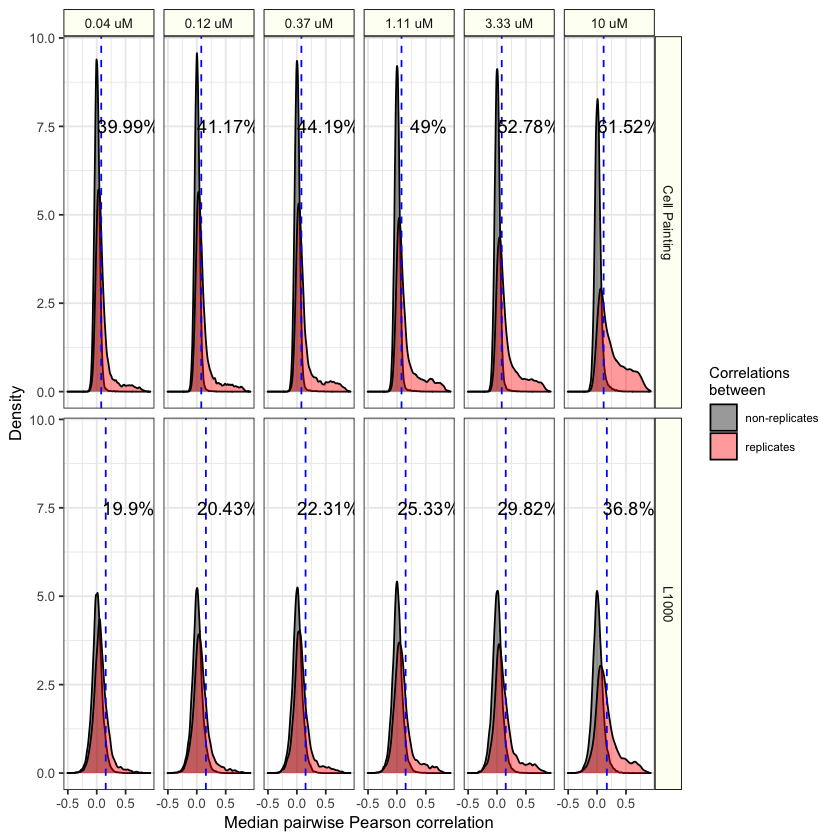

In [7]:
panel_a_gg <- (
    ggplot(pr_df, aes(x = correlation_values))
    + geom_density(aes(fill = type), alpha = 0.4)
    + facet_grid("assay~dose")
    + geom_vline(data = threshold_df, linetype = "dashed", color = "blue", aes(xintercept=threshold))
    + geom_text(data = percent_replicating_df, aes(label = percent_replicating, x = 0.55, y = 7.5))
    + theme_bw()
    + figure_theme
    + scale_fill_manual("Correlations\nbetween", labels = replicate_labels, values = replicate_colors)
    + xlab("Median pairwise Pearson correlation")
    + ylab("Density")
)

panel_a_gg

### Panel B

In [8]:
cell_painting_compound_score_file <- file.path(results_dir, "median_score_per_compound_CellPainting.tsv.gz")
l1000_compound_score_file <- file.path(results_dir, "median_score_per_compound_l1000.tsv.gz")

In [9]:
comp_col_types <- readr::cols(
    compound = readr::col_character(),
    no_of_replicates = readr::col_double(),
    dose = readr::col_character(),
    median_replicate_score = readr::col_double()
)

cell_painting_comp_df <- readr::read_tsv(cell_painting_compound_score_file, col_types = comp_col_types) %>% dplyr::mutate(assay = "Cell Painting")
l1000_comp_df <- readr::read_tsv(l1000_compound_score_file, col_types = comp_col_types) %>% dplyr::mutate(assay = "L1000")

In [10]:
significant_compounds_df <- cell_painting_comp_df %>%
    dplyr::left_join(l1000_comp_df, by = c("dose", "compound"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "Cell Painting"), by = "dose") %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "L1000"), by = "dose", suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = median_replicate_score_cellpainting > threshold_cellpainting,
        pass_l1000_thresh = median_replicate_score_l1000 > threshold_l1000
    ) %>%
    dplyr::select(compound, dose, pass_cellpainting_thresh, pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

head(significant_compounds_df)

Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”
Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”


compound,dose,pass_cellpainting_thresh,pass_l1000_thresh,pass_both
<chr>,<chr>,<lgl>,<lgl>,<lgl>
17-hydroxyprogesterone-caproate,0.04 uM,FALSE,FALSE,FALSE
2-iminobiotin,0.04 uM,FALSE,FALSE,FALSE
3-amino-benzamide,0.04 uM,TRUE,FALSE,FALSE
3-deazaadenosine,0.04 uM,FALSE,FALSE,FALSE
ABT-737,0.04 uM,FALSE,FALSE,FALSE
AICA-ribonucleotide,0.04 uM,FALSE,FALSE,FALSE


In [11]:
pass_thresh_summary_df <- significant_compounds_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

pass_thresh_summary_df

dose,num_pass_cellpainting,num_pass_l1000,num_pass_both,unique_pass_cellpainting,unique_pass_l1000
<chr>,<int>,<int>,<int>,<int>,<int>
0.04 uM,413,171,101,312,70
0.12 uM,422,184,115,307,69
0.37 uM,465,208,146,319,62
1.11 uM,542,249,192,350,57
3.33 uM,620,321,258,362,63
10 uM,793,425,378,415,47


In [12]:
cell_painting_rect <- pass_thresh_summary_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = ymax_bar / 2
    )

l1000_rect <- pass_thresh_summary_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 25
    )

full_rect = dplyr::bind_rows(cell_painting_rect, l1000_rect)
full_rect

dose,ymax_bar,unique_pass,num_pass_both,ymin_bar,xmin_bar,xmax_bar,assay,label_text_y
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.04 uM,413,312,101,0,0,1,Cell Painting,206.5
0.12 uM,422,307,115,0,2,3,Cell Painting,211.0
0.37 uM,465,319,146,0,4,5,Cell Painting,232.5
1.11 uM,542,350,192,0,6,7,Cell Painting,271.0
3.33 uM,620,362,258,0,8,9,Cell Painting,310.0
10 uM,793,415,378,0,10,11,Cell Painting,396.5
0.04 uM,483,70,101,312,0,1,L1000,458.0
0.12 uM,491,69,115,307,2,3,L1000,466.0
0.37 uM,527,62,146,319,4,5,L1000,502.0


In [13]:
num_pass_both_text <- full_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + (num_pass_both / 2))

num_pass_both_text

dose,xmin_bar,ymax_bar,num_pass_both,ymin_l1000_bar,label_text_y
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
0.04 uM,0,413,101,312,362.5
0.12 uM,2,422,115,307,364.5
0.37 uM,4,465,146,319,392.0
1.11 uM,6,542,192,350,446.0
3.33 uM,8,620,258,362,491.0
10 uM,10,793,378,415,604.0


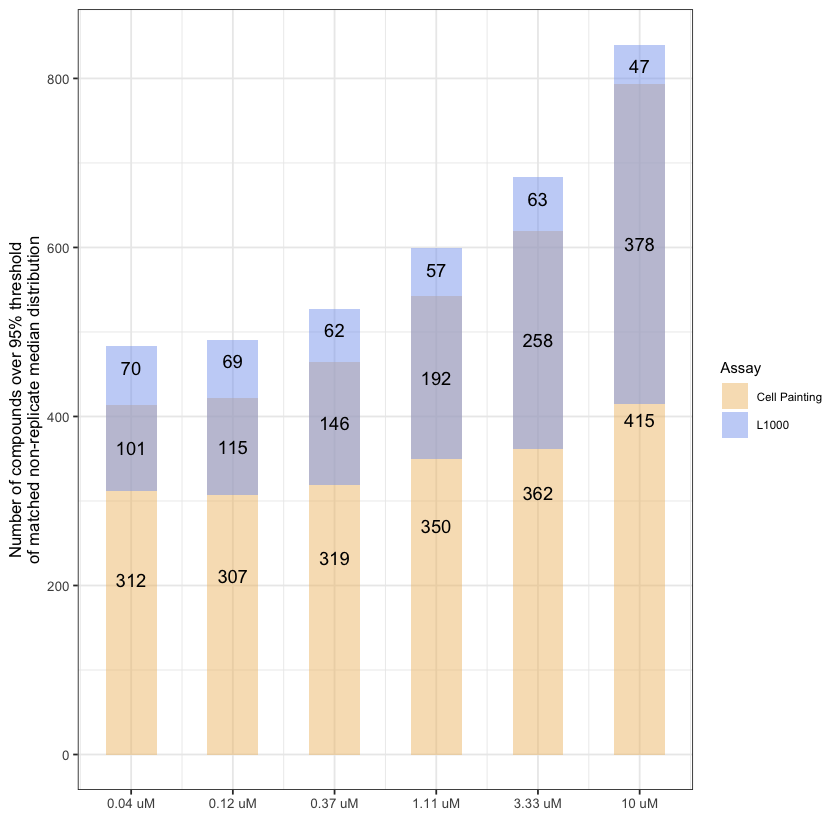

In [14]:
panel_b_gg <- (
    ggplot(full_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    + scale_fill_manual("Assay", values = assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(labels = num_pass_both_text$dose, breaks = seq(0.5, length(num_pass_both_text$dose) * 2, 2))
    + ylab("Number of compounds over 95% threshold\nof matched non-replicate median distribution")
    + xlab("")
)

panel_b_gg

### Panel C

In [15]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

cell_painting_pm_pval_file <- file.path(
    results_dir, "cell_painting", "moa_sizes_consensus_datasets",
    "matching_score_per_MOA_CellPainting_p_values_compared_to_nonparametric_null.tsv.gz"
)
l1000_pm_pval_file <- file.path(
    results_dir, "L1000", "moa_sizes_consensus_datasets",
    "matching_score_per_MOA_L1000_p_values_compared_to_nonparametric_null.tsv.gz"
)

cell_painting_pm_file <- file.path(
    results_dir, "cell_painting", "moa_sizes_consensus_datasets",
    "matching_score_per_MOA_CellPainting.tsv.gz"
)
l1000_pm_file <- file.path(
    results_dir, "L1000", "moa_sizes_consensus_datasets",
    "matching_score_per_MOA_L1000.tsv.gz"
)

In [16]:
p_val_alpha_thresh <- 0.05
no_replicates_thresh <- 3

pm_col_types <- readr::cols(
    dose = readr::col_character(),
    matching_score = readr::col_double(),
    no_of_replicates = readr::col_double()
)

cell_painting_pm_df <- readr::read_tsv(cell_painting_pm_file, col_types = pm_col_types) %>%
    dplyr::mutate(assay = "Cell Painting") %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- readr::read_tsv(l1000_pm_file, col_types = pm_col_types) %>%
    dplyr::mutate(assay = "L1000") %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

pm_pval_col_types <- readr::cols(
    dose = readr::col_character(),
    p_value = readr::col_double(),
    no_of_replicates = readr::col_double()
)

cell_painting_pm_pval_df <- readr::read_tsv(cell_painting_pm_pval_file, col_types = pm_pval_col_types) %>%
    dplyr::mutate(assay = "Cell Painting") %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- readr::read_tsv(l1000_pm_pval_file, col_types = pm_pval_col_types) %>%
    dplyr::mutate(assay = "L1000") %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1674    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,-0.30778432,Cell Painting,0.777,FALSE,0.10957898
acetylcholine receptor agonist,9,0.04 uM,0.24852150,Cell Painting,0.396,FALSE,0.40230481
acetylcholine receptor antagonist,21,0.04 uM,0.03242155,Cell Painting,0.370,FALSE,0.43179828
acetylcholinesterase inhibitor,3,0.04 uM,-0.25501783,Cell Painting,0.777,FALSE,0.10957898
adenosine receptor agonist,3,0.04 uM,-0.28565722,Cell Painting,0.916,FALSE,0.03810453
adenosine receptor antagonist,5,0.04 uM,0.23485644,Cell Painting,0.243,FALSE,0.61439373


In [17]:
percent_matching_df <- pm_df %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::mutate(percent_matching = paste0(100 * round((sum(pass_thresh) / length(pass_thresh)), 4), "%")) %>%
    dplyr::select(dose, assay, percent_matching) %>%
    dplyr::distinct()

percent_matching_df

dose,assay,percent_matching
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,12.24%
0.12 uM,Cell Painting,16.33%
0.37 uM,Cell Painting,18.37%
1.11 uM,Cell Painting,19.73%
3.33 uM,Cell Painting,21.09%
10 uM,Cell Painting,21.77%
0.04 uM,L1000,8.33%
0.12 uM,L1000,8.33%
0.37 uM,L1000,14.39%


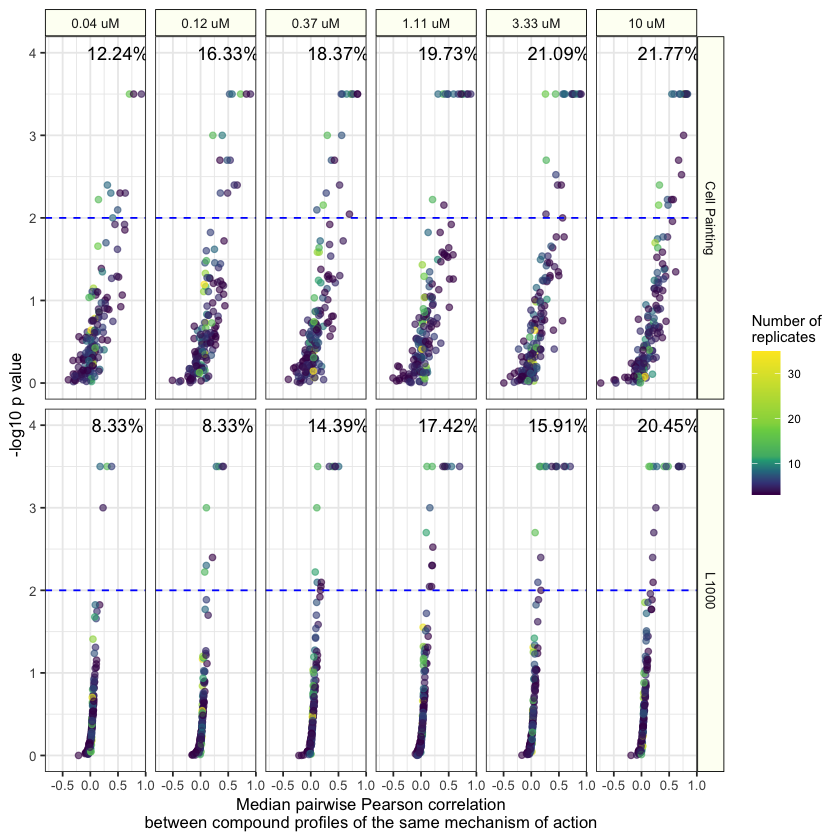

In [18]:
panel_c_gg <- (
    ggplot(pm_df, aes(x = matching_score, y = neg_log_10_p_val))
    + geom_point(aes(color = no_of_replicates), alpha = 0.6)
    + geom_text(data = percent_matching_df, aes(label = percent_matching, x = 0.5, y = 4))
    + facet_grid("assay~dose")
    + geom_hline(linetype = "dashed", color = "blue", yintercept = 2)
    + theme_bw()
    + figure_theme
    + scale_color_continuous("Number of\nreplicates", values = scales::rescale(c(0, 2, 4, 6, 8, 15, 30)), type = "viridis")
    + xlab("Median pairwise Pearson correlation\nbetween compound profiles of the same mechanism of action")
    + ylab("-log10 p value")
)

panel_c_gg

### Panel D

In [19]:
significant_moa_df <- cell_painting_pm_pval_df %>%
    dplyr::left_join(l1000_pm_pval_df, by = c("dose", "moa"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::mutate(
        pass_cellpainting_thresh = p_value_cellpainting < p_val_alpha_thresh,
        pass_l1000_thresh = p_value_l1000 < p_val_alpha_thresh
    ) %>%
    dplyr::select(moa, dose, pass_cellpainting_thresh, pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

pass_thresh_summary_moa_df <- significant_moa_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

cell_painting_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = 4
    )

l1000_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 3
    )

full_moa_rect <- dplyr::bind_rows(cell_painting_moa_rect, l1000_moa_rect)

num_pass_both_moa_text <- full_moa_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_moa_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + num_pass_both / 2)

In [20]:
num_pass_both_moa_text

dose,xmin_bar,ymax_bar,num_pass_both,ymin_l1000_bar,label_text_y
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
0.04 uM,0,16,4,12,14.0
0.12 uM,2,21,6,15,18.0
0.37 uM,4,23,9,14,18.5
1.11 uM,6,24,14,10,17.0
3.33 uM,8,25,16,9,17.0
10 uM,10,25,19,6,15.5


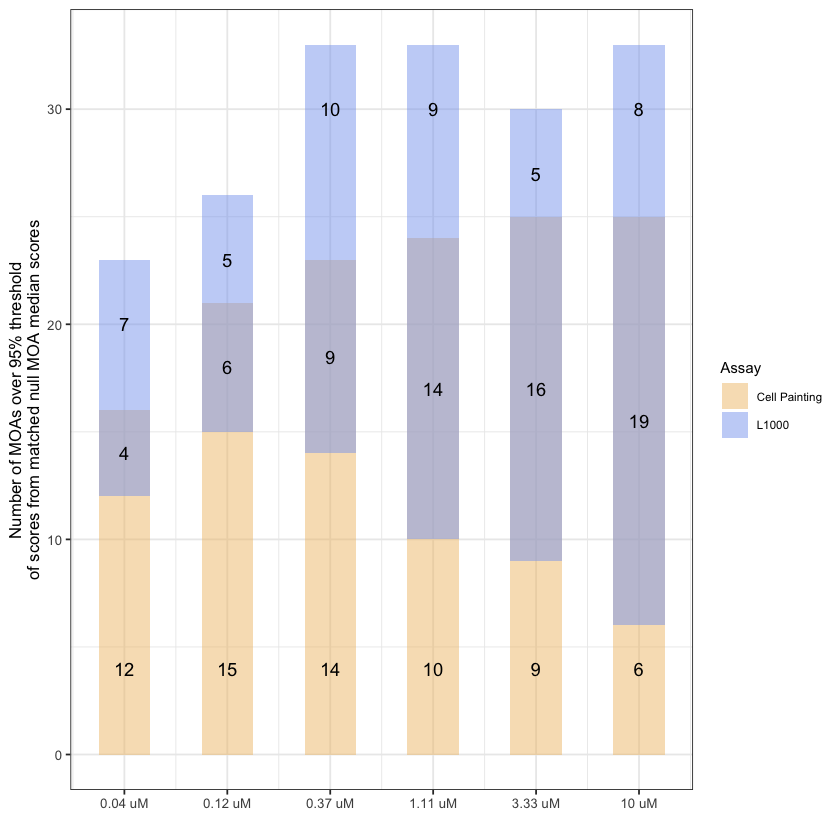

In [21]:
panel_d_gg <- (
    ggplot(full_moa_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_moa_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    + scale_fill_manual("Assay", values = assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(labels = num_pass_both_moa_text$dose, breaks = seq(0.5, length(num_pass_both_moa_text$dose) * 2, 2))
    + ylab("Number of MOAs over 95% threshold\nof scores from matched null MOA median scores")
    + xlab("")
)

panel_d_gg

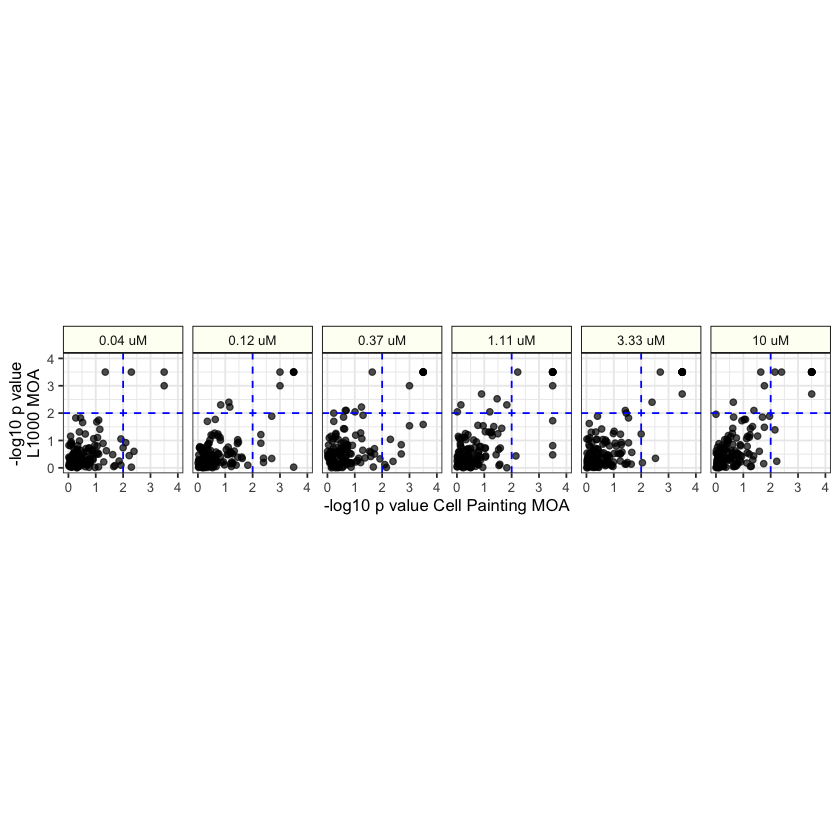

In [22]:
moa_compare_pval_df <- cell_painting_pm_pval_df %>%
    dplyr::left_join(l1000_pm_pval_df, by = c("dose", "moa"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::mutate(
        neg_log_10_p_val_cp = -log10(p_value_cellpainting),
        neg_log_10_p_val_l1000 = -log10(p_value_l1000),
        pass_cellpainting_thresh = p_value_cellpainting < p_val_alpha_thresh,
        pass_l1000_thresh = p_value_l1000 < p_val_alpha_thresh
    )

moa_compare_pval_df$neg_log_10_p_val_cp[moa_compare_pval_df$neg_log_10_p_val_cp == Inf] = 3.5
moa_compare_pval_df$neg_log_10_p_val_l1000[moa_compare_pval_df$neg_log_10_p_val_l1000 == Inf] = 3.5

moa_compare_pval_df$dose <- factor(moa_compare_pval_df$dose, levels = dose_order)

sup_maybe_gg <- (
    ggplot(moa_compare_pval_df, aes(x = neg_log_10_p_val_cp, y = neg_log_10_p_val_l1000))
    + geom_point(alpha = 0.7)
    + geom_hline(linetype = "dashed", color = "blue", yintercept = 2)
    + geom_vline(linetype = "dashed", color = "blue", xintercept = 2)
    + figure_theme
    + facet_grid("~dose")
    + coord_fixed()
    + xlab("-log10 p value Cell Painting MOA")
    + ylab("-log10 p value\nL1000 MOA")
    + ylim(c(0, 4))
    + xlim(c(0, 4))
)

sup_maybe_gg

### Panel E

In [23]:
# Load profiles for heatmap prep
results_dir <- file.path("../1.Data-exploration/Consensus/")

cell_painting_profile_file <- file.path(
    results_dir, "cell_painting", "moa_sizes_consensus_datasets",
    "cell_painting_moa_analytical_set_profiles.tsv.gz"
)
l1000_profile_file <- file.path(
    results_dir, "L1000", "moa_sizes_consensus_datasets",
    "l1000_moa_analytical_set_profiles.tsv.gz"
)

cp_profile_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_cell_id = readr::col_character(),
    Metadata_broad_sample = readr::col_character(),
    Metadata_pert_well = readr::col_character(),
    Metadata_time_point = readr::col_character(),
    Metadata_moa = readr::col_character(),
    Metadata_target = readr::col_character(),
    broad_id = readr::col_character(),
    pert_iname = readr::col_character(),
    moa = readr::col_character()
)

l1000_profile_cols <- readr::cols(
    .default = readr::col_double(),
    sig_id = readr::col_character(),
    pert_id = readr::col_character(),
    pert_idose = readr::col_character(),
    pert_iname = readr::col_character(),
    moa = readr::col_character()
)

cp_profile_df <- readr::read_tsv(cell_painting_profile_file, col_types = cp_profile_cols)
cp_profile_df$Metadata_dose_recode <- dplyr::recode(paste(cp_profile_df$Metadata_dose_recode), !!!dose_rename)
cp_profile_df$Metadata_dose_recode <- factor(cp_profile_df$Metadata_dose_recode, levels = dose_order)

l1000_profile_df <- readr::read_tsv(l1000_profile_file, col_types = l1000_profile_cols) %>%
    rename(Metadata_dose_recode = dose)
l1000_profile_df$Metadata_dose_recode <- dplyr::recode(paste(l1000_profile_df$Metadata_dose_recode), !!!dose_rename)
l1000_profile_df$Metadata_dose_recode <- factor(l1000_profile_df$Metadata_dose_recode, levels = dose_order)

common_perts <- intersect(
    unique(cp_profile_df$pert_iname),
    unique(l1000_profile_df$pert_iname)
)

cp_profile_df <- cp_profile_df %>% dplyr::filter(pert_iname %in% !!common_perts)
l1000_profile_df <- l1000_profile_df %>% dplyr::filter(pert_iname %in% !!common_perts)

In [24]:
target_moa <- "plk inhibitor"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_a_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

In [25]:
target_moa <- "tubulin inhibitor"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_b_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

In [26]:
target_moa <- "cdk inhibitor"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_c_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

In [27]:
target_moa <- "hsp inhibitor"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_d_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

In [28]:
cor_legend <- cowplot::get_legend(compound_a_gg)

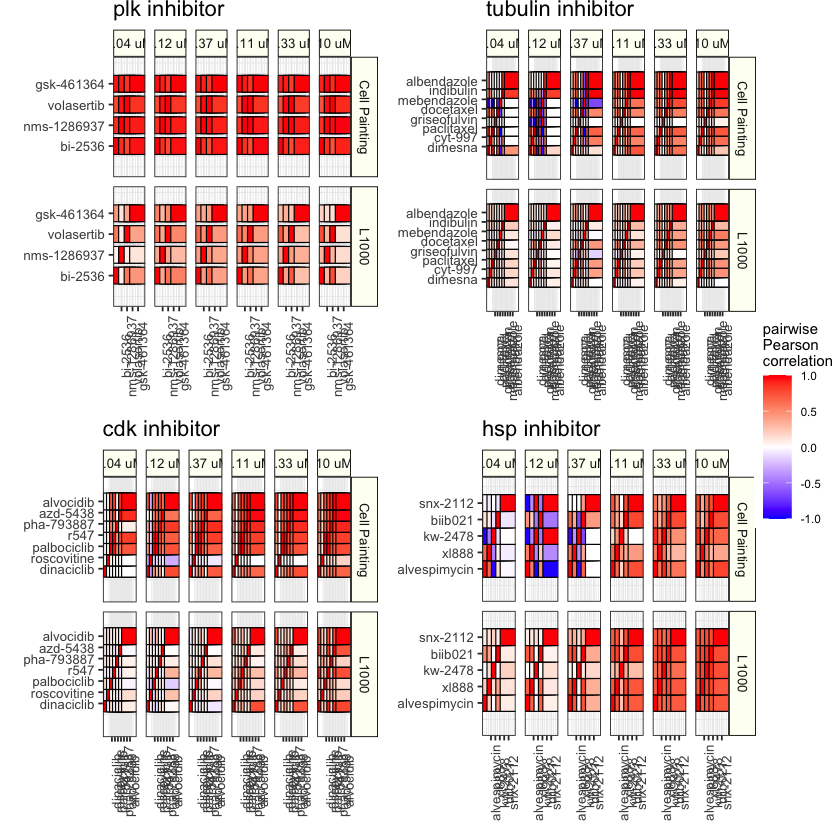

In [29]:
panel_e_gg <- cowplot::plot_grid(
    cowplot::plot_grid(
        compound_a_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"), legend.position = "none"),
        compound_b_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"), legend.position = "none"),
        compound_c_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"), legend.position = "none"),
        compound_d_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm"), legend.position = "none"),
        nrow = 2
    ),
    cor_legend,
    ncol = 2,
    rel_widths = c(0.9, 0.1)
)

panel_e_gg

### Compile figure panels together

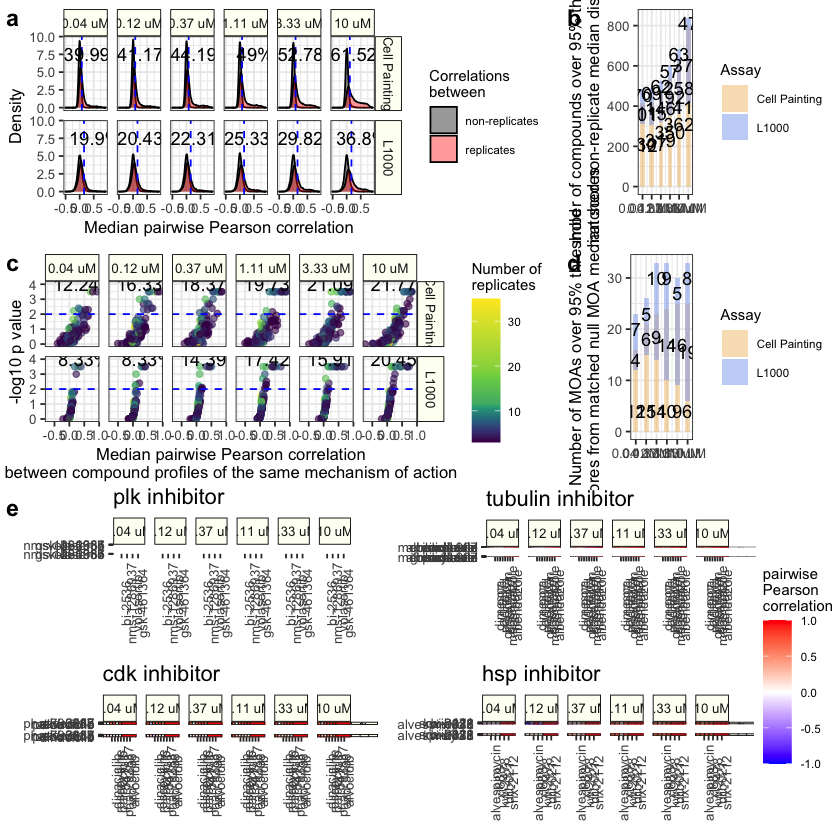

In [30]:
figure_1_gg <- cowplot::plot_grid(
    cowplot::plot_grid(
        panel_a_gg,
        panel_b_gg,
        ncol = 2,
        rel_widths = c(1, 0.5),
        labels = c("a", "b")
    ),
    cowplot::plot_grid(
        panel_c_gg,
        panel_d_gg,
        ncol = 2,
        rel_widths = c(1, 0.5),
        labels = c("c", "d")
    ),
    panel_e_gg,
    nrow = 3,
    labels = c("", "", "e"),
    rel_heights = c(0.7, 0.7, 1)
)

figure_1_gg

In [31]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure_1_gg, base_width = 16, base_height = 16, dpi = 500)
}